# HW10. Оценивание плотностей. Непараметрическая регрессия.
#### Ильичёв А.С., 693

In [109]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
from statsmodels.stats.multitest import multipletests
import statsmodels as sm
from tqdm import tqdm
import scipy.interpolate as interp
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer



%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 5) 

# Задача 2

In [2]:
df = pd.read_table('glass.dat', delim_whitespace=True)

/home/artur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [3]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
1,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,WinF
2,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,WinF
3,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,WinF
4,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,WinF
5,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,WinF


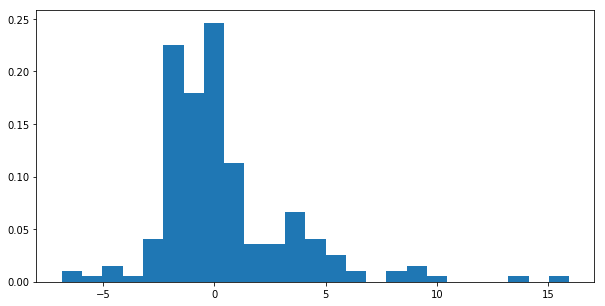

In [8]:
values = df['RI']
plt.hist(values, bins=25, density=True);

Выберем $h_n$ как среднее расстояний от $X_i$ до 10-го ближайшего соседа.

In [9]:
k = 10
h10 = np.mean([sorted(np.abs(values - x))[k] for x in values])
h10

0.5008878504672897

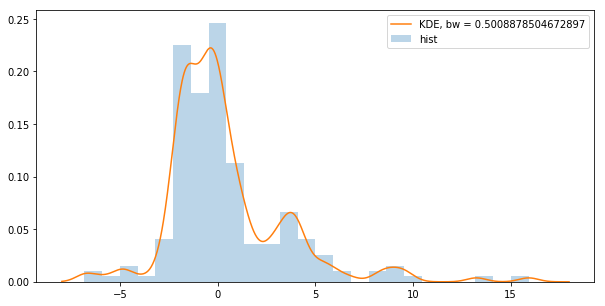

In [10]:
np.random.seed(1234)  # Seed random generator
kde = sm.nonparametric.kde.KDEUnivariate(values)
kde.fit(bw=h10)
xs = np.linspace(-8, 18, 1000)
plt.hist(values, bins=25, density=True, label='hist', alpha=0.3)
density = [kde.evaluate(x) for x in xs]
plt.plot(xs, density, label='KDE, bw = {}'.format(h10))
plt.legend()
plt.show()


По теореме о ядерной оценке разность между kde и истинным значением плотности имеет нормальное распределение, поэтому можно использовать бутстрепный нормальный доверительный интервал.

In [11]:
alpha = 0.95
u = sts.norm.ppf((1 + alpha) / 2)
u

1.959963984540054

In [12]:
# число бутстрепных выборок
straps_num = 1000
# номер n, с которого начинается подсчет
start_from = 5
def bootstrap(values):
    var_strap = [None] * len(xs)
    samples = np.random.choice(values, size=(straps_num, len(values)))
    dens = np.zeros((straps_num, len(xs)))
    for i, sample in tqdm(enumerate(samples)):
        kde = sm.nonparametric.kde.KDEUnivariate(sample)
        kde.fit(bw=h10)
        dens[i] = [kde.evaluate(x) for x in xs]


    for j, x in tqdm(enumerate(xs)):
        ests_strap = dens[:, j]
        var_strap[j] = np.mean(ests_strap**2) - (np.mean(ests_strap))**2
    return var_strap

In [13]:
var_strap = bootstrap(values)

1000it [00:29, 33.42it/s]
1000it [00:00, 32905.02it/s]


In [18]:
boot_lefts = np.maximum([(density[i] - u * np.sqrt(var_strap[i])) for i in range(len(xs))], 0).squeeze()
boot_rights = np.squeeze([(density[i] + u * np.sqrt(var_strap[i])) for i in range(len(xs))])

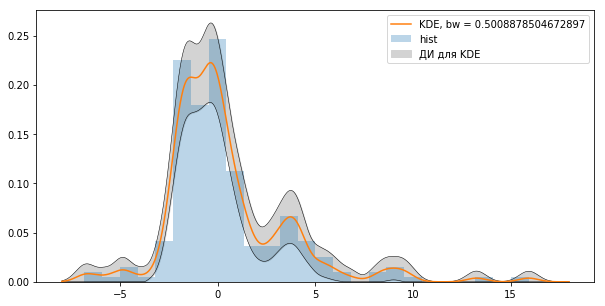

In [19]:
plt.hist(values, bins=25, density=True, label='hist', alpha=0.3)
plt.plot(xs, boot_lefts, c='black', linewidth=0.5)
plt.plot(xs, boot_rights, c='black', linewidth=0.5)
plt.fill_between(xs, boot_lefts, boot_rights, color='lightgrey', label='ДИ для KDE')
plt.plot(xs, density, label='KDE, bw = {}'.format(h10))
plt.legend()
plt.show()

# Задача 3

In [25]:
df = pd.read_csv('hw10t3.csv', index_col=0)
df.head()

,y,x
0,0.064771,0.180249
1,-0.683449,-0.811201
2,0.501485,-0.616333
3,0.263588,-0.749556
4,-0.323165,-0.414561


In [26]:
X = df['x']
Y = df['y']

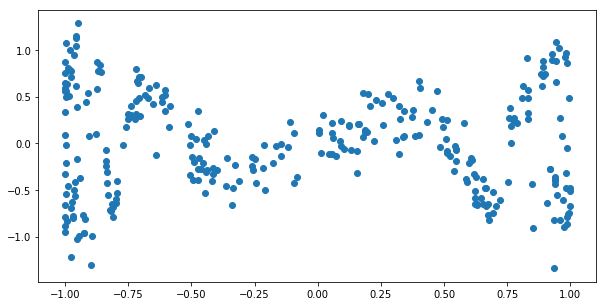

In [31]:
plt.scatter(X, Y);

In [32]:
xs = np.linspace(-1, 1, 1000)

Метод Надарая-Ватсона.

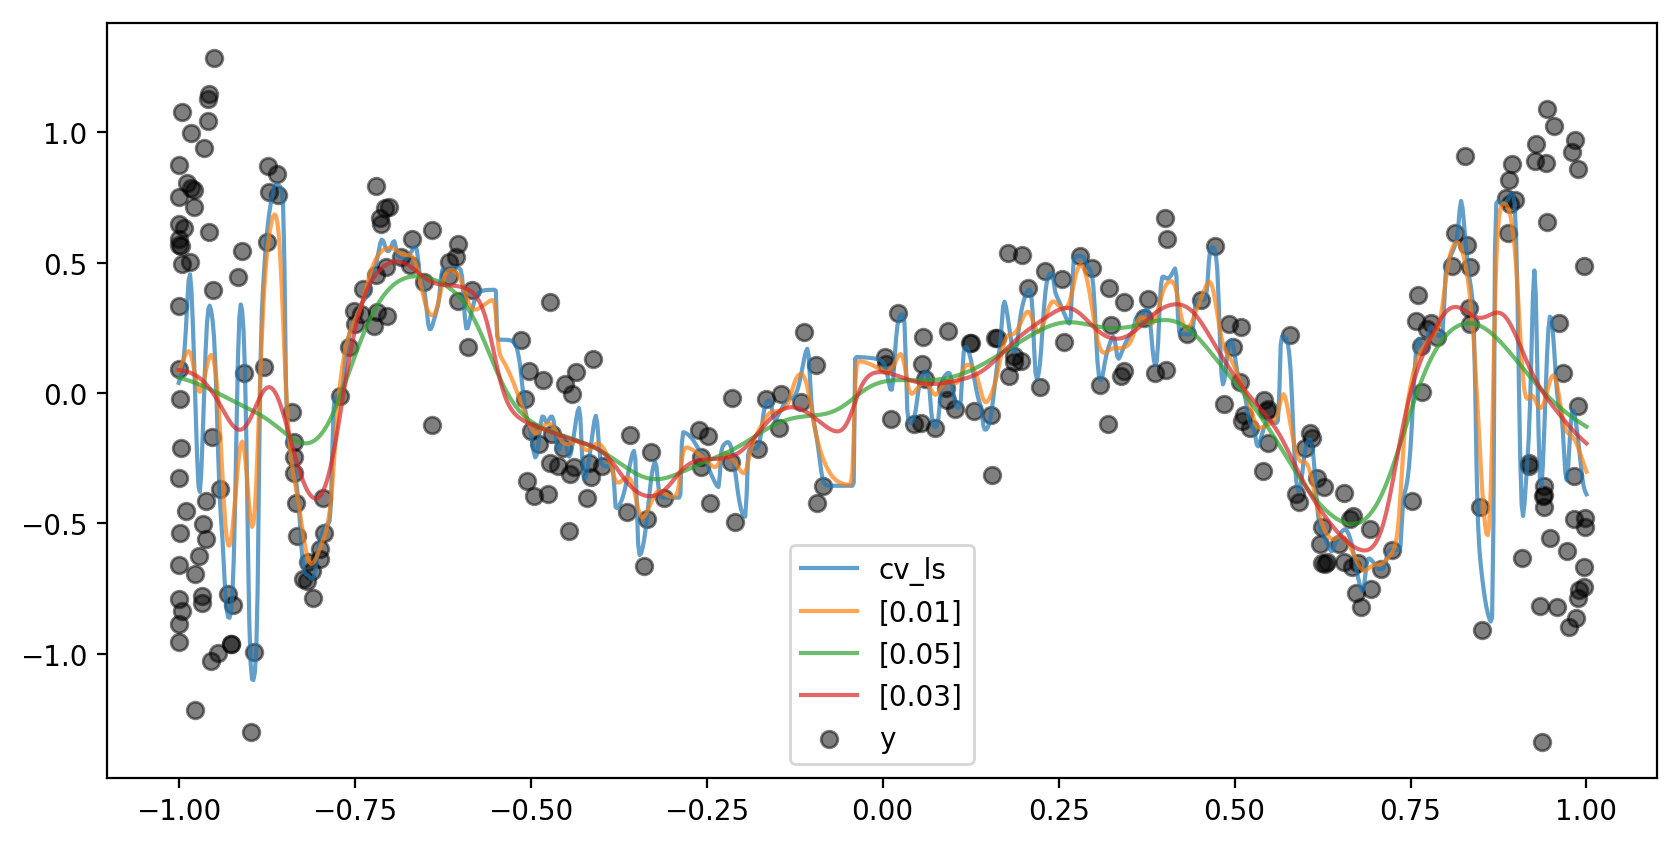

In [51]:
plt.figure(dpi=200)
plt.scatter(X, Y, c='black', alpha=0.5)
for bw in ['cv_ls', [0.01], [0.05], [0.03]]:
    kerreg = sm.nonparametric.kernel_regression.KernelReg([Y], [X], var_type='c', reg_type='lc', bw=bw)
    kerreg_est = kerreg.fit(xs)
    plt.plot(xs, kerreg_est[0], label = str(bw), alpha=0.7)
plt.legend()
plt.show()

При автоматическом подборе bw по кросс-валидации и при маленьких его значениях регрессия слишком сильно переобучается на выборку, при больших - не отражает зависимость вблизи концов отрезка. Оптимальным из этих выглядит значение 0.03.

В выражении для сплайна интеграл имеет роль "регуляризации" для второй производной, не давая функции совершать резкие скачки. Я, к сожалению, не знаю R, поэтому буду использовать функцию из scipy, использующую похожую идею, но другой метод.

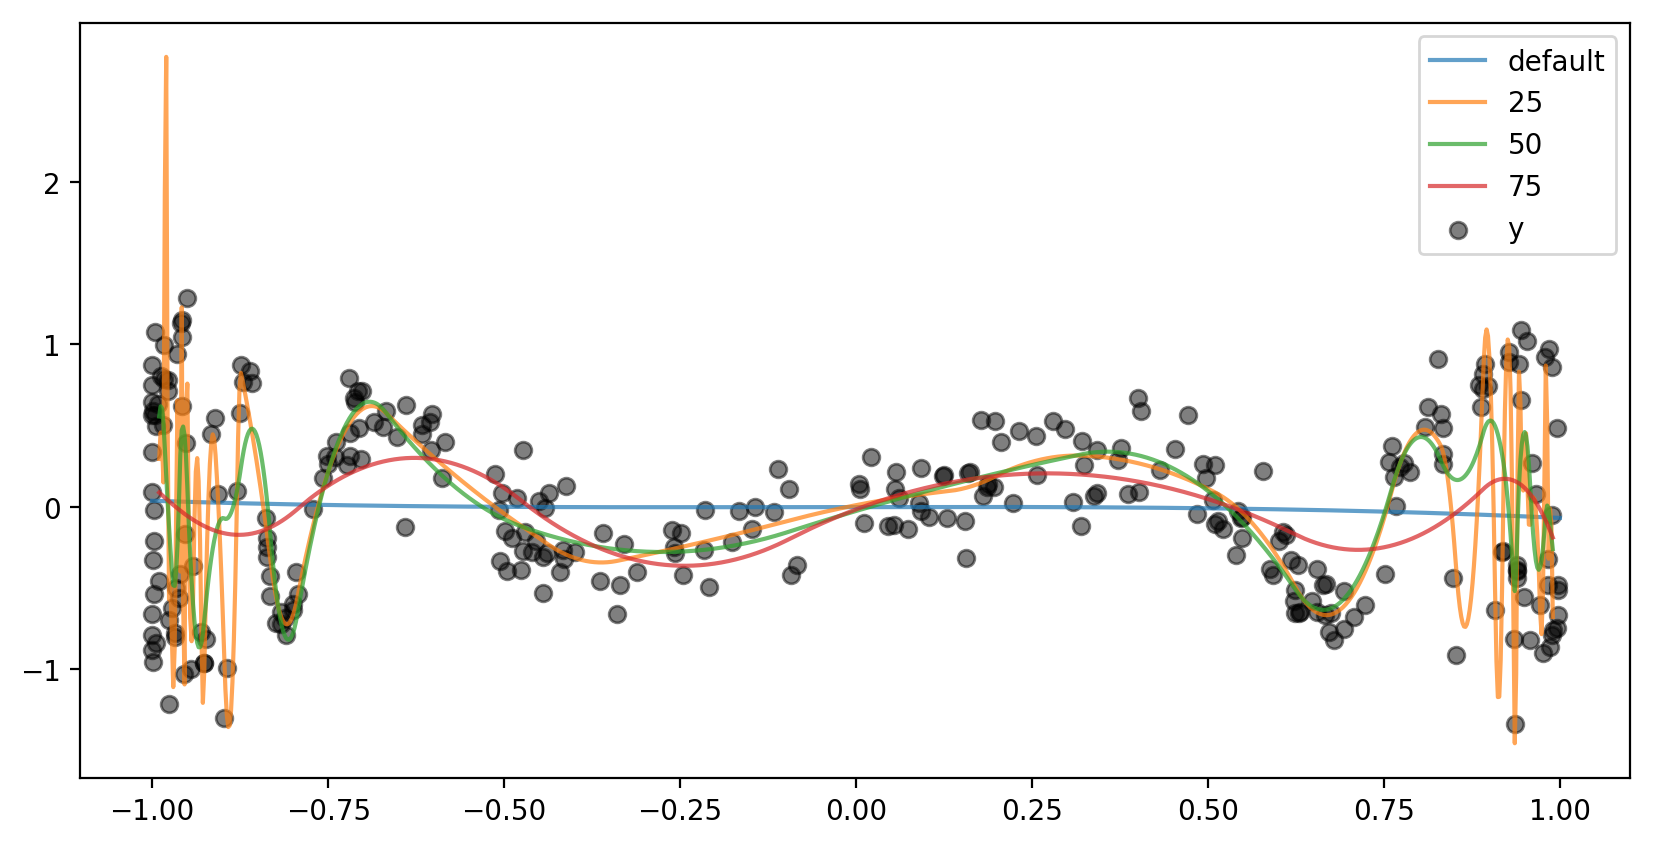

In [71]:
indices = np.argsort(X)
plt.figure(dpi=200)
plt.scatter(X, Y, c='black', alpha=0.5)
spl = interp.UnivariateSpline(X[indices], Y[indices])
plt.plot(xs, spl(xs), label = 'default', alpha=0.7)
for sm_factor in [25, 50, 75]:
    spl = interp.UnivariateSpline(X[indices], Y[indices], s=sm_factor, k=2)
    plt.plot(xs[5:-5], spl(xs[5:-5]), label = str(sm_factor), alpha=0.7)
plt.legend()
plt.show()


Оптимальным значением здесь кажется 50. Сплайн более гладкий в центральной части графика, но сильнее осциллирует по краям (особенно при малом коэффициенте сглаживания). Это происходит из-за того, что сплайн не использует локальное усреднение, а штрафует себя за поточечные ошибки. По краям много точек, поэтому сплайн старается подстроиться под них. При этом сплайн представляет собой сшитые полиномы, поэтому он более гладкий.

# Задача 4

In [77]:
df = pd.read_csv('hw10t4.csv', index_col=0)
df.head()

,Andrew,Bernard,Carle,Davide,Eugene,Fred,George,Marmaduke
0,-36.944209,7.115482,3.076607,1.832458,2.059673,0.112941,-0.706182,5.409550
1,-76.268155,9.871361,1.854843,1.628231,2.818672,0.061049,-0.595321,4.869631
2,-45.020962,7.772921,1.019105,1.595419,-0.906164,0.236599,-1.759698,3.493061
3,-31.935210,6.670168,2.117598,-1.274111,1.835605,0.270813,1.996759,4.904334
4,-40.738145,7.432577,0.048449,-0.865901,2.321549,0.086520,1.720531,3.247345


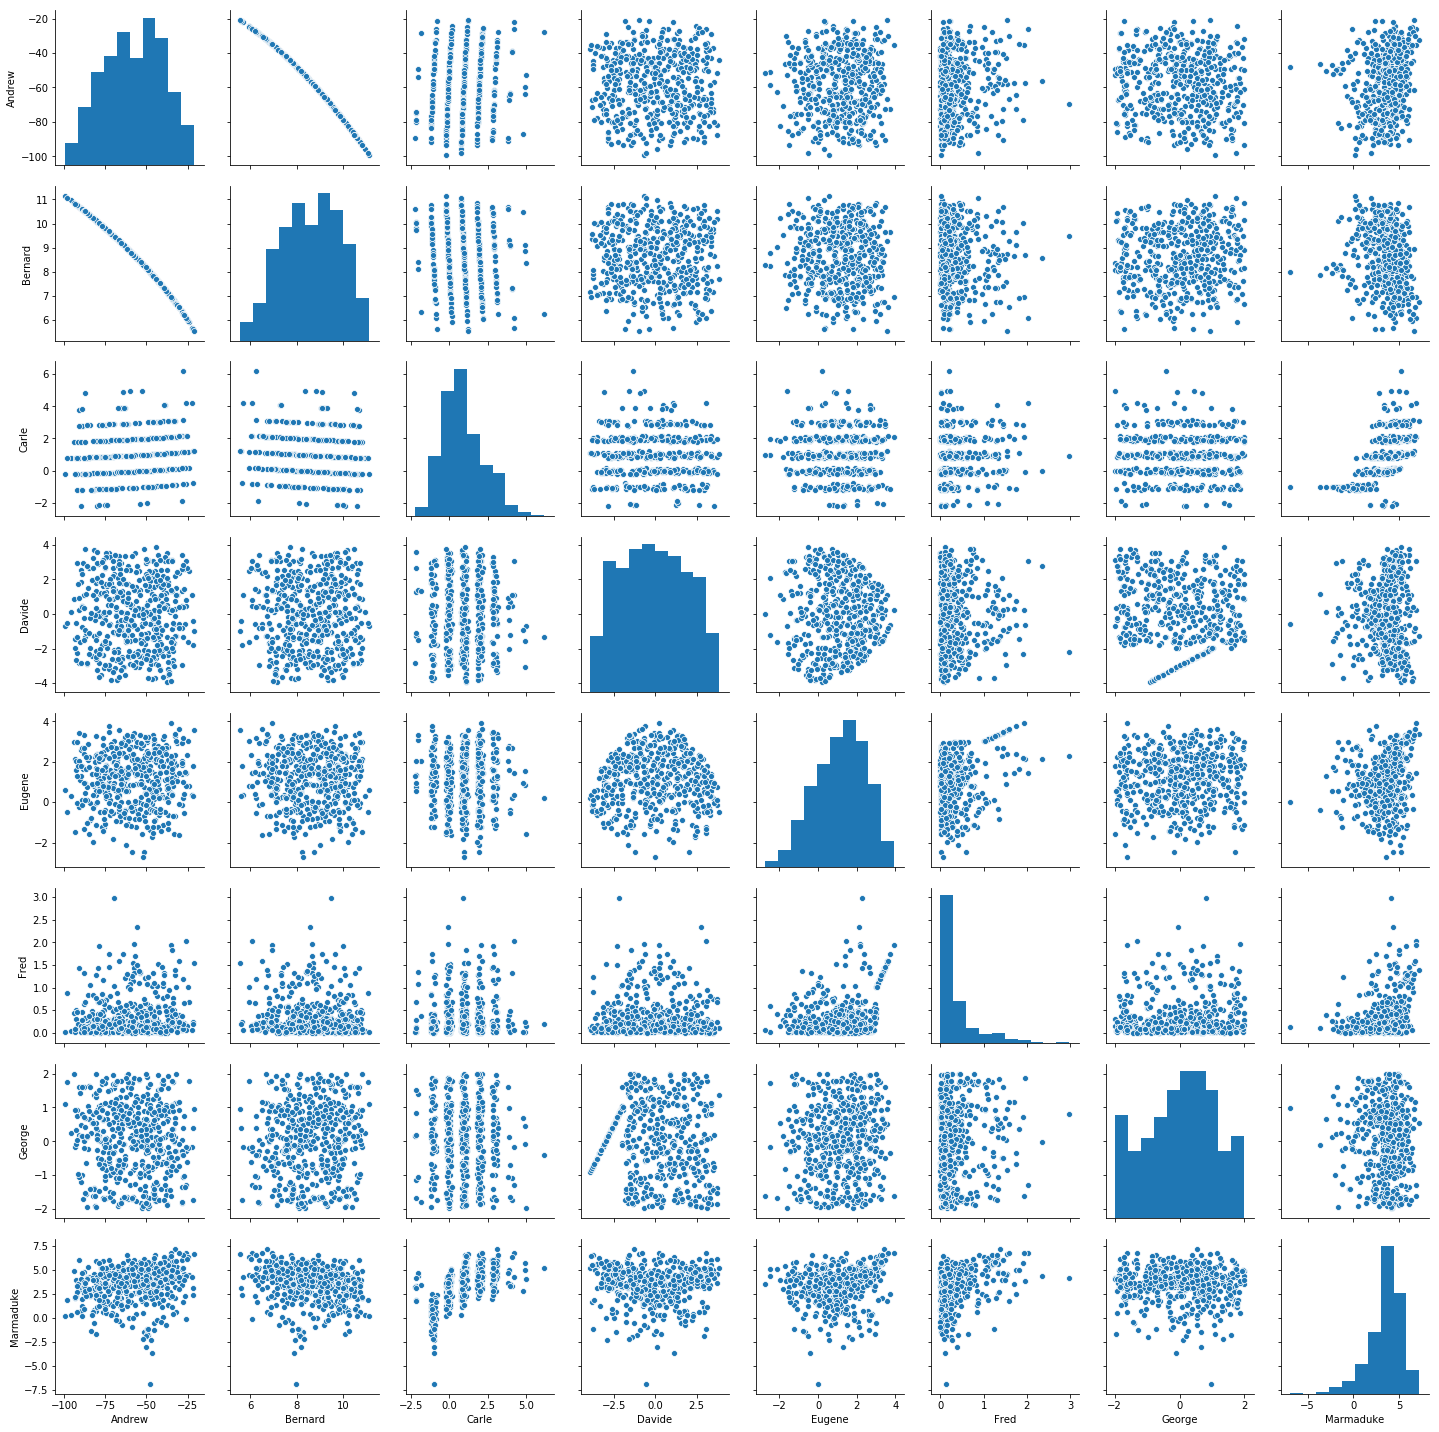

In [80]:
sns.pairplot(df);

Видим выброс по целевой переменной, уберем его. Кроме того, признаки Bernard и Andrew практически линейно зависимы, уберем их.

In [86]:
sts.spearmanr(df['Andrew'], df['Bernard'])

SpearmanrResult(correlation=-0.9999999999999998, pvalue=0.0)

In [82]:
df['Marmaduke'].idxmin()

303

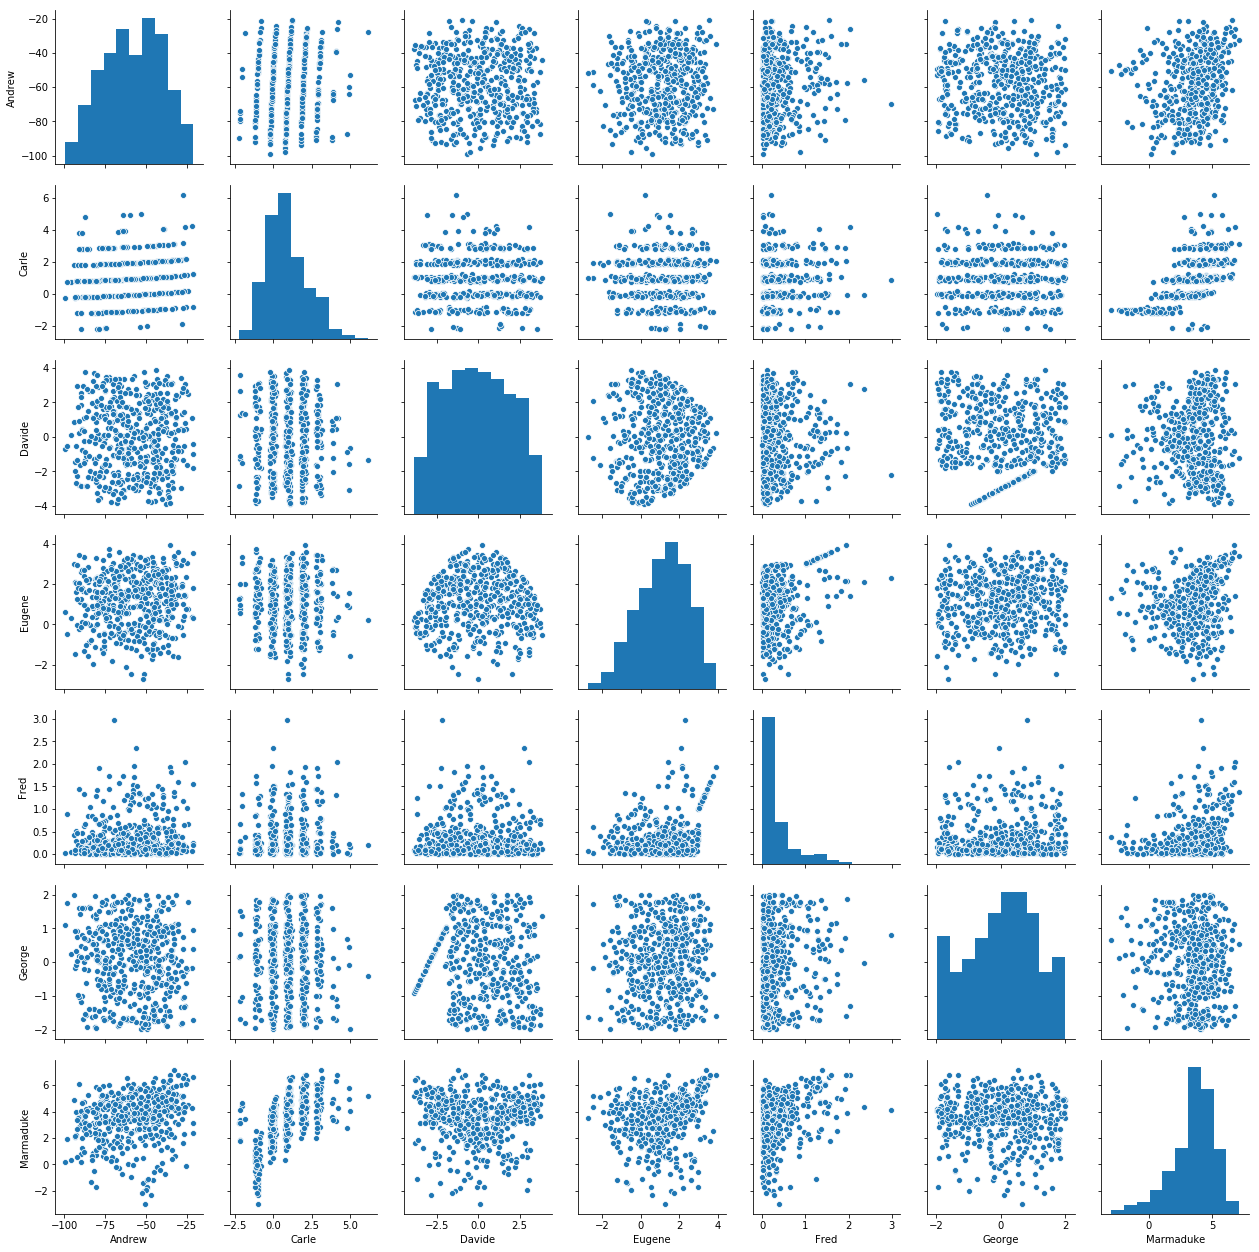

In [92]:
df_cut = df.drop(df['Marmaduke'].idxmin(), 0).drop('Bernard', 1)
sns.pairplot(df_cut);

In [93]:
X_train, y_train = df_cut.drop('Marmaduke', 1), df_cut['Marmaduke']

### Линейная регрессия

In [90]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [142]:
linreg = LinearRegression()
scores = -cross_val_score(linreg, X_train, y_train, scoring=rmse_scorer, cv=6)
np.mean(scores)

1.2498832894783516

### Надарай-Ватсон

In [133]:
kerreg = sm.nonparametric.kernel_regression.KernelReg([y_train],
                np.array(X_train).T, var_type='cccccc', reg_type='lc')

/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:228: RuntimeWarning: invalid value encountered in true_divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:215: RuntimeWarning: invalid value encountered in true_divide
  G = G_numer / G_denom
/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:227: RuntimeWarning: divide by zero encountered in true_divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:227: RuntimeWarning: invalid value encountered in true_divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:227: RuntimeWarning: invalid value encountered in subtract
  B_x = d_mx / f_x - G * d_fx / f_x


In [134]:
preds = kerreg.fit(np.array(X_train).T)[0]

In [135]:
rmse(preds, y_train)

0.23096189791090946

In [139]:
kf = KFold(n_splits=6)
scores = []
X_train_arr = np.array(X_train)
for train_index, test_index in tqdm(kf.split(X_train_arr)):
    X_train_cv, X_test = X_train_arr[train_index], X_train_arr[test_index]
    y_train_cv, y_test = np.array(y_train)[train_index], np.array(y_train)[test_index]
    kerreg = sm.nonparametric.kernel_regression.KernelReg([y_train_cv],
                X_train_cv.T, var_type='cccccc', reg_type='lc')
    preds = kerreg.fit(X_test.T)[0]
    scores.append(rmse(preds, y_test))








0it [00:00, ?it/s]






1it [03:10, 190.74s/it]/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:215: RuntimeWarning: invalid value encountered in true_divide
  G = G_numer / G_denom
/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:227: RuntimeWarning: invalid value encountered in true_divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:228: RuntimeWarning: invalid value encountered in true_divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)







2it [06:21, 190.64s/it]/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:215: RuntimeWarning: invalid value encountered in true_divide
  G = G_numer / G_denom
/home/artur/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_regression.py:227: RuntimeWarning: invalid value encoun

In [141]:
np.mean(scores)

0.6438321696383024

Результат значительно лучше,чем у линейной регрессии. Но работает модель очень долго.

### Настройка с возвращением.

Будем делать 50 шагов настройки.

In [208]:
def fit_predict_tuning(X_train, X_test, y_train, y_test, n_columns):
    linreg.fit(X_train, y_train)
    a = linreg.coef_
    train_values = np.zeros_like(X_train)
    test_values = np.zeros_like(X_test)
    for j in range(n_columns):
        train_values[:, j] = a[j] * X_train[:, j]
    phis = [(lambda x:  x) for j in range(len(linreg.coef_))]
    for i in range(50):
        for j in range(n_columns):
            z = y_train - np.sum(train_values, axis=1) + train_values[:, j]
            kerreg = sm.nonparametric.kernel_regression.KernelReg([z], [X_train[:, j]], var_type='c', reg_type='lc', bw=bw)
            preds = kerreg.fit(X_test[:, j])[0]
            test_values[:,j] = np.nan_to_num(preds, np.nanmean(preds))
            train_preds = kerreg.fit(X_train[:, j])[0]
            train_values[:,j] = np.nan_to_num(train_preds, np.nanmean(train_preds))
    preds = np.sum(test_values, axis=1)
    return preds

In [209]:
import warnings
warnings.simplefilter("ignore")

kf = KFold(n_splits=6)
scores = []
X_train_arr = np.array(X_train)
for train_index, test_index in tqdm(kf.split(X_train_arr)):
    X_train_cv, X_test = X_train_arr[train_index], X_train_arr[test_index]
    y_train_cv, y_test = np.array(y_train)[train_index], np.array(y_train)[test_index]
    preds = fit_predict_tuning(X_train_cv, X_test, y_train_cv, y_test, len(X_train.columns))
    scores.append(rmse(preds, y_test))








0it [00:00, ?it/s]






1it [00:22, 22.11s/it]






2it [00:44, 22.12s/it]






3it [01:07, 22.54s/it]






4it [01:31, 22.81s/it]






5it [01:54, 22.90s/it]






6it [02:17, 22.90s/it]

In [210]:
np.mean(scores)

0.8236376320705222

Результат лучше, чем у линейной регрессии, но хуже, чем у оценки Надарая-Ватсона для всей выборки. (примерно такой же был на 30 итерациях алгоритма, так что его можно считать стабилизовавшимся)